In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_predict
from scipy.stats import binomtest
from sklearn.model_selection import permutation_test_score


In [3]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index = questions.index.rename('q_id')

In [4]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief'}, axis=1, inplace=True)
data.rename({'Unnamed: 0': 'user_id'}, axis=1, inplace=True)

In [5]:
descriptive_questions = [column for column in data.columns if column.startswith('q')] + ['gender']
#questions.loc['gender', :] = None
questions.loc['gender', 'text'] = 'Gender?'
display(questions.loc[descriptive_questions].head())



,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q49,Which word describes you better?,Carefree,Intense,NaN,NaN,49827.0,N,NaN,descriptive
q50,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507.0,O,NaN,descriptive
q60,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205.0,O,NaN,descriptive
q61,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174.0,O,NaN,descriptive
q63,Which word describes you better?,Private,Social,NaN,NaN,23765.0,O,NaN,descriptive


In [6]:
# per question count number of times the question is answered
n_answers_per_question = data[descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

,text
q416235,Do you like watching foreign movies with subti...
q85419,Which type of wine would you prefer to drink o...
gender,Gender?
q358084,Do you enjoy intense intellectual conversations?
q501,Have you smoked a cigarette in the last 6 months?
q77,How frequently do you drink alcohol?
q20930,Rate your self-confidence:
q29829,How often do you keep your promises?
q35660,How often are you open with your feelings?
q80,What's your deal with harder drugs (stuff beyo...


# Top K questions df

In [7]:
features_df = data[descriptive_questions]
print(features_df.shape)

(36085, 830)


In [8]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [9]:
# biggest k with >10.000 subjects who answered ALL k questions
n_most_answered = next(x[0] for x in enumerate(subset_size_topk) if x[1] <= 10000)
n_most_answered

49

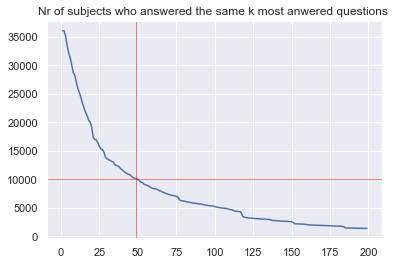

In [10]:
g = sns.lineplot(x = range(1,K), y = subset_size_topk)
g.axhline(y=10000, color='red', linewidth=0.5)
g.axvline(x=n_most_answered, color='red', linewidth=0.5)

#plt.ylim(0,len(features_df))
g.set_title('Nr of subjects who answered the same k most anwered questions ')
plt.show()

# Feature Encoding und Selection

In [11]:
top_questions = sorted_questions[:n_most_answered].to_list()
features_df = features_df[top_questions]
target = data.loc[features_df.index][['political_belief']]

In [12]:
# X_train, X_val, y_train, y_val = train_test_split(features_df, target, test_size=0.15, random_state=1)
# X_train.shape, X_val.shape
# feature_encoder = OneHotEncoder()
# target_encoder = OneHotEncoder()
# X_train_encoded = feature_encoder.fit_transform(X_train)
# y_train_encoded = target_encoder.fit_transform(y_train)
# X_val_encoded = feature_encoder.fit(X_val)
# y_val_encoded = feature_encoder.fit(y_val)

In [13]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

In [14]:
fs = SelectKBest(score_func=chi2, k=20)
fs.fit(X_train_encoded, y_train_encoded)
X_train_best_feat = fs.transform(X_train_encoded)
display(X_train_best_feat.shape)
fs.scores_.shape
selected_questions = np.argpartition(fs.scores_, -20)[-20:]
selected_questions = selected_questions[np.argsort(fs.scores_[selected_questions])][::-1]

 

(36085, 20)

Feature 0: How important are your political beliefs to you?: 1396.4425043980066
Feature 1: Gender?: 1021.6009542236345
Feature 2: How often do you keep your promises?: 528.0941651166117
Feature 3: Do you say 'Thank you' to wait staff when served in a restaurant?: 454.3716110332296
Feature 4: Are you an aspiring actor/artist/writer or other creative type?: 445.52126660156813
Feature 5: Are you ready to settle down and get married right now?: 372.98034740840166
Feature 6: Do you litter?: 363.7239393200779
Feature 7: You're dating someone new. You discover that they have a housemate the same sex as you. This:: 358.4066012656885
Feature 8: If you had to name your greatest motivation in life thus far, what would it be?: 334.46508883641206
Feature 9: How frequently do you bathe or shower?: 329.0136967742067
Feature 10: What's your relationship with marijuana?: 320.61282472954065
Feature 11: How frequently do you drink alcohol?: 279.7066216563472
Feature 12: Do you like watching foreign movie

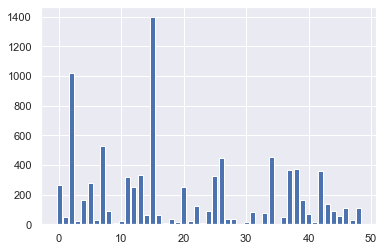

In [15]:
for i, score in enumerate(fs.scores_[selected_questions]):
    print(f'Feature {i}: {questions.loc[sorted_questions[selected_questions[i]]].text}: {score}')

# plot the scores
plt.bar(range(len(fs.scores_)), fs.scores_)
plt.show()

# Model Selection

In [16]:
# Naive Bayes Hyper parameter Tuning
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
nb = CategoricalNB(fit_prior=False)
clf = GridSearchCV(nb, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

mean test score [0.44312207 0.44312207 0.44327223 0.44301176 0.44360551 0.44089503
 0.36584383]
best estimator CategoricalNB(alpha=10, fit_prior=False)


In [17]:
# Logistic Regression
# one hot encoding for Logistic Regression 
feature_encoder = OneHotEncoder()
X_train_best_feat_1hot = feature_encoder.fit_transform(X_train_best_feat)
print(X_train_best_feat_1hot.shape)

(36085, 84)


In [18]:
parameters = {'C': [0.001, 0.01, 1, 10, 100]}
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=300, random_state=42)
clf = GridSearchCV(logreg, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

mean test score [0.46137525 0.46673761 0.46762968 0.46768542 0.46796524]
best estimator LogisticRegression(C=100, class_weight='balanced', max_iter=300,
                   random_state=42)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
parameters = { 
    'n_estimators': [50, 500],
    'min_samples_leaf' : [0.1, 5, 10],
}

# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(criterion='entropy', random_state=42, class_weight='balanced')
clf = GridSearchCV(rf, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

KeyboardInterrupt: 

# Permutation Test
I would do all of the evaluation on the test set, instead of here!

References:

[1]
Ojala and Garriga. Permutation Tests for Studying Classifier Performance. The Journal of Machine Learning Research (2010) vol. 11

In [36]:


rng = np.random.RandomState(seed=0)
# Use same number of samples and features as in the original data 
X_rand = np.random.permutation(X_train_best_feat)

clf = CategoricalNB(fit_prior=False)
cv = StratifiedKFold(2, shuffle=True, random_state=1)


In [47]:
score_data, perm_scores_data, pvalue_data = permutation_test_score(
    clf, X_train_best_feat, y_train_encoded, scoring="balanced_accuracy", cv=cv, n_permutations=100
)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y_train_encoded, scoring="balanced_accuracy", cv=cv, n_permutations=100
)

Below we plot a histogram of the permutation scores (the null distribution). The red line indicates the score obtained by the classifier on the original data. The score is much better than those obtained by using permuted data and the p-value is thus very low. This indicates that there is a low likelihood that this good score would be obtained by chance alone. It provides evidence that the dataset contains real dependency between features and labels and the classifier was able to utilize this to obtain good results.

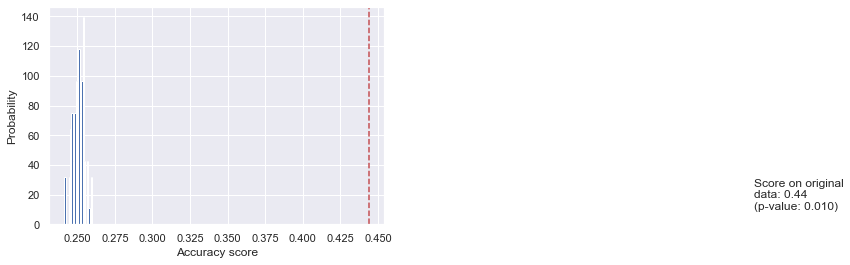

In [48]:
fig, ax = plt.subplots()

ax.hist(perm_scores_data, bins=20, density=True)
ax.axvline(score_data, ls="--", color="r")
score_label = f"Score on original\ndata: {score_data:.2f}\n(p-value: {pvalue_data:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

Below we plot the null distribution for the randomized data. The permutation scores are similar to those obtained using the original dataset because the permutation always destroys any feature label dependency present. The score obtained on the original randomized data in this case though, is very poor. This results in a large p-value, confirming that there was no feature label dependency in the original data.

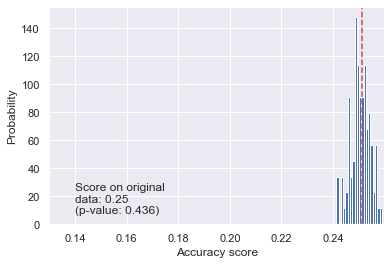

In [49]:
fig, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls="--", color="r")
score_label = f"Score on original\ndata: {score_rand:.2f}\n(p-value: {pvalue_rand:.3f})"
ax.text(0.14, 7.5, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()

# Evaluation

In [ ]:
# Naive Bayes
clf = CategoricalNB(fit_prior=False)
y_pred = cross_val_predict(clf, X_train_best_feat, y_train_encoded, cv=10)
print(target_encoder.classes_)
conf_mat = confusion_matrix(y_train_encoded, y_pred, normalize='true', labels=range(4))
crossval_accuracy = accuracy_score(y_train_encoded, y_pred)
f1 = f1_score(y_train_encoded, y_pred, average='weighted')
recall = recall_score(y_train_encoded, y_pred, average='weighted')
print('crossval accuracy', crossval_accuracy)
print('f1 ', f1)
print('recall ', recall)
print(conf_mat)


['Centrist' 'Conservative / Right-wing' 'Liberal / Left-wing' 'Other']
crossval accuracy 0.4442011916308716
f1  0.467931132050789
recall  0.4442011916308716
[[0.40274059 0.24980312 0.22601985 0.12143645]
 [0.24869635 0.52025672 0.11913357 0.11191336]
 [0.23159212 0.13825461 0.54407257 0.0860807 ]
 [0.22304139 0.25199858 0.21602416 0.30893587]]


['Centrist' 'Conservative / Right-wing' 'Liberal / Left-wing' 'Other']


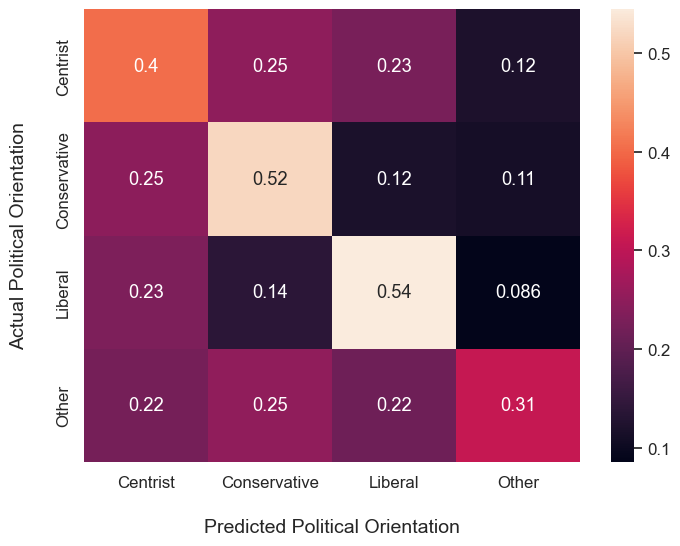

In [ ]:
print(target_encoder.classes_)

plotting.plot_confusion_matrix(conf_mat, labels=['Centrist', 'Conservative', 'Liberal', 'Other'])

### To-Dos:
- Data Distribution 
- Cross Validation for the 3 best model configurations
- Compute Confustion Matrix and other evaluations
- Decide which classifier to use
- Significance test
- Random features: scramble targets --> significance test

### Questions for Auguste:
- One-hot passt?
- Reicht balanced bei model? -> nicht features angepasst
- Signifance test?

# Data Distributions

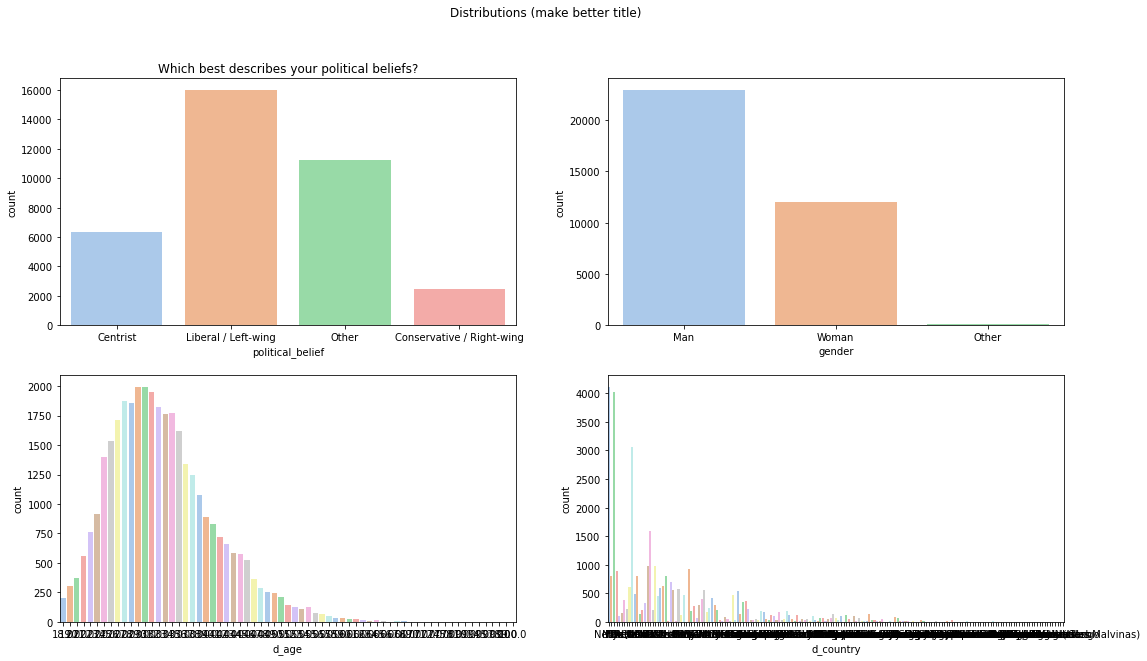

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distributions (make better title)')

 
sns.countplot(ax=axes[0, 0], data=data, x='political_belief', palette="pastel").set(title=questions.loc['q212813', 'text'])
sns.countplot(ax=axes[0, 1], data=data, x='gender', palette="pastel")
sns.countplot(ax=axes[1, 0], data=data, x='d_age', palette="pastel")
sns.countplot(ax=axes[1, 1], data=data, x='d_country', palette="pastel")
plt.show()

In [ ]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
data['n_q_answered'] = data[descriptive_questions].count(axis=1)

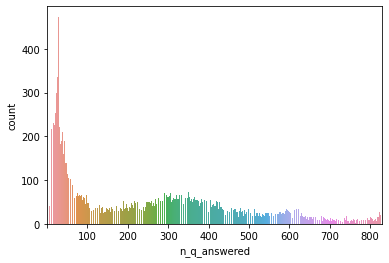

In [ ]:
ax = sns.countplot(x=data['n_q_answered'])
ax.set_xticks(range(-2, data['n_q_answered'].max(), 100))
plt.show()